In [1]:
import pickle
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import quandl
import nltk
import itertools
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import collections
from sklearn.manifold import Isomap,MDS
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
def reset_seed():
    torch.manual_seed(1)
    np.random.seed(1)

In [3]:
def plot_3d_scatter(data):
    fig = pyplot.figure()
    ax = Axes3D(fig)
    color=['r','b']
    isomap=Isomap(n_components=3)
    _=isomap.fit_transform(data.iloc[:,:-1].values)
    for c in range(class_number):
        d=isomap.transform(data[(data['Last']==c)].values[:,:-1])
        ax.scatter(d[:,2], d[:,1], d[:,0],c=color[c])

In [4]:
lmap=lambda fun,it:list(map(lambda x:fun(x),it))

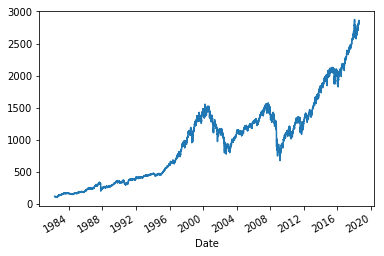

In [5]:
spy = quandl.get("CHRIS/CME_SP1", authtoken="CTq2aKvtCkPPgR4L_NFs")

spy=spy.fillna(method='ffill').fillna(method='bfill')

spy['Last'].plot()

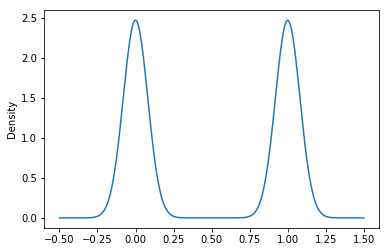

In [6]:
labels=np.log((spy['Last'].shift(-1)/spy['Last'])).dropna()

class_number=2

labels=pd.qcut(spy['Last'].pct_change().shift(-1).fillna(0),labels=range(class_number),q=class_number).astype(int)

labels.plot.density()

## 1. DNN Experiments

### 1.1 Build DNN Classifier

In [7]:
# -*- coding:utf-8 -*-

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F
import numpy as np
import os


class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, class_number):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc_out = nn.Linear(hidden_size // 2, class_number)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        output = self.relu(self.fc1(x))
        output = self.relu(self.fc2(output))
        output = self.fc_out(output)
        output = self.softmax(output)
        return output


class DNNClassifier(object):
    def __init__(self, input_size, hidden_size, class_number):
        super(DNNClassifier, self).__init__()
        self.dnn = DNN(input_size, hidden_size, class_number=class_number)
        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.dnn.parameters(), lr=1e-3)
    
    def train(self, X, y):
        batch_x = torch.tensor(X)
        batch_y = torch.tensor(y)
#         batch_x = (batch_x-batch_x.mean(dim=1,keepdim=True))/batch_x.mean(dim=1,keepdim=True)
        instance_num = batch_y.shape[0]
        self.optimizer.zero_grad()
        y_hat = self.dnn(batch_x)
        loss = self.loss_func(y_hat, batch_y)
        loss.backward()
        clip_grad_norm_(self.dnn.parameters(), 1)
        self.optimizer.step()
        topv, topi = y_hat.topk(1)
        incorrect = float(torch.sign((topi.view(-1) - batch_y).abs()).sum().item())
        acc = (instance_num - incorrect) / instance_num
        return loss.item(), acc
    
    def test(self, X, y):
        batch_x = torch.tensor(X)
        batch_y = torch.tensor(y)
#         batch_x = (batch_x-batch_x.mean(dim=0,keepdim=True))/batch_x.mean(dim=0,keepdim=True)
        instance_num = batch_y.shape[0]
        y_hat = self.dnn(batch_x).detach()
        loss = self.loss_func(y_hat, batch_y)
        topv, topi = y_hat.topk(1)
        incorrect = float(torch.sign((topi.view(-1) - batch_y).abs()).sum().item())
        acc = (instance_num - incorrect) / instance_num
        return loss.item(), acc

In [8]:
def test(x,y,model,batch_size=128,epoch=100,log_interval=10):
    batch_size=batch_size
    train_size=int(0.8*y.shape[0])
    test_size=y.shape[0]-train_size
    random_index=np.arange(x.shape[0])
    np.random.shuffle(random_index)
    train_x=x[random_index][:train_size]
    train_y=y[random_index][:train_size]
    test_x=x[random_index][train_size:]
    test_y=y[random_index][train_size:]
    train_loss=[]
    train_acc=[]
    dev_loss=[]
    dev_acc=[]
    for e in range(epoch):
        pointer=0
        epoch_train_loss=[]
        epoch_train_acc=[]
        train_random_index=np.arange(train_y.shape[0])
        np.random.shuffle(train_random_index)
        train_x=train_x[train_random_index]
        train_y=train_y[train_random_index]
        while pointer<train_size:
            batch_x=train_x[pointer:pointer+batch_size]
            batch_y=train_y[pointer:pointer+batch_size]
            loss,acc=model.train(X=batch_x,y=batch_y)
            epoch_train_loss.append(loss)
            epoch_train_acc.append(acc)
            pointer+=batch_size
        train_loss.append(np.mean(epoch_train_loss))
        train_acc.append(np.mean(epoch_train_acc))
        loss,acc=model.test(X=test_x,y=test_y)
        dev_loss.append(loss)
        dev_acc.append(acc)
        if e % log_interval ==0:
            print('test loss',loss,'test acc',acc,'epoch:',e)
    return train_loss,train_acc,dev_loss,dev_acc

### 1.2 Experiment of RNN auto-encoder encoded title, (mean with date)

In [9]:
reset_seed()

In [10]:
ae_date_index=np.load('data/date_index_ae.npy')
ae_encoded_title=np.load('data/encoded_title_ae.npy')

In [11]:
ae_encoded_title=pd.DataFrame(ae_encoded_title)

ae_date_index=pd.DataFrame(ae_date_index,columns=['date'])

ae_encoded_title=ae_date_index.join(ae_encoded_title)

ae_encoded_title.index=ae_encoded_title.date
ae_encoded_title.drop('date',axis=1,inplace=True)

mean_ae_encoded_title=ae_encoded_title.groupby('date').mean()

In [12]:
ae_data_set=mean_ae_encoded_title.join(labels).fillna(method='bfill').dropna()

# ae_data_set.to_csv('data/ae_embedding.csv')

x=np.array(ae_data_set.iloc[:,:-1].values,dtype=np.float32)

y=np.array(ae_data_set.iloc[:,-1].values,dtype=int)

In [13]:
model=DNNClassifier(input_size=50,hidden_size=50,class_number=class_number)

In [14]:
train_loss,train_acc,dev_loss,dev_acc=test(model=model,x=x,y=y)

test loss 0.6929680705070496 test acc 0.534375 epoch: 0
test loss 0.6926447749137878 test acc 0.5375 epoch: 10
test loss 0.6918430328369141 test acc 0.5375 epoch: 20
test loss 0.6917827129364014 test acc 0.521875 epoch: 30
test loss 0.6909998655319214 test acc 0.509375 epoch: 40
test loss 0.6923260688781738 test acc 0.525 epoch: 50
test loss 0.6927862167358398 test acc 0.528125 epoch: 60
test loss 0.6926764249801636 test acc 0.515625 epoch: 70
test loss 0.6938314437866211 test acc 0.525 epoch: 80
test loss 0.693346381187439 test acc 0.521875 epoch: 90


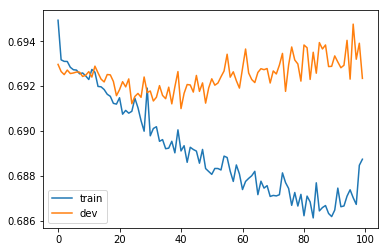

In [15]:
plt.plot(train_loss)
plt.plot(dev_loss)
plt.legend(('train','dev'))

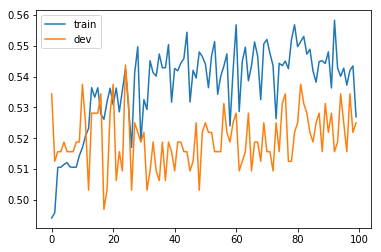

In [16]:
plt.plot(train_acc)
plt.plot(dev_acc)
plt.legend(('train','dev'))

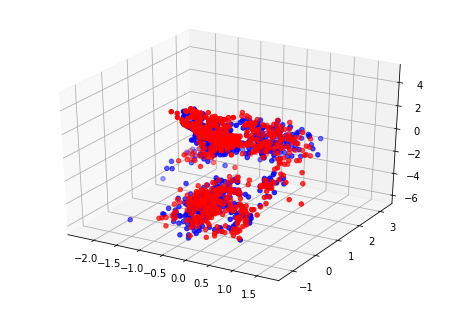

In [17]:
plot_3d_scatter(ae_data_set)

### 1.3 Experiment of pure Glove word embedding titles (mean with each title, mean with date)

In [18]:
reset_seed()

In [19]:
mean_title=pd.read_csv('data/mean_titles.csv')

mean_title.index=mean_title.date

mean_title.drop('date',axis=1,inplace=True)

mean_data_set=mean_title.join(labels).fillna(method='bfill').dropna()

In [20]:
# mean_data_set.to_csv('data/mean_embedding.csv')

x=np.array(mean_data_set.iloc[:,:-1].values,dtype=np.float32)

y=np.array(mean_data_set.iloc[:,-1].values,dtype=int)

In [21]:
model=DNNClassifier(input_size=300,hidden_size=50,class_number=class_number)

In [22]:
train_loss,train_acc,dev_loss,dev_acc=test(model=model,x=x,y=y)

test loss 0.6930760145187378 test acc 0.515625 epoch: 0
test loss 0.6919849514961243 test acc 0.528125 epoch: 10
test loss 0.6907473802566528 test acc 0.5375 epoch: 20
test loss 0.6902903318405151 test acc 0.553125 epoch: 30
test loss 0.6924869418144226 test acc 0.5125 epoch: 40
test loss 0.6946593523025513 test acc 0.51875 epoch: 50
test loss 0.6984986066818237 test acc 0.503125 epoch: 60
test loss 0.7000682353973389 test acc 0.528125 epoch: 70
test loss 0.7035843133926392 test acc 0.525 epoch: 80
test loss 0.707969069480896 test acc 0.515625 epoch: 90


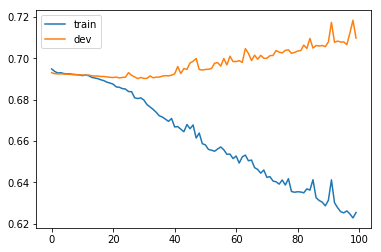

In [23]:
plt.plot(train_loss)
plt.plot(dev_loss)
plt.legend(('train','dev'))

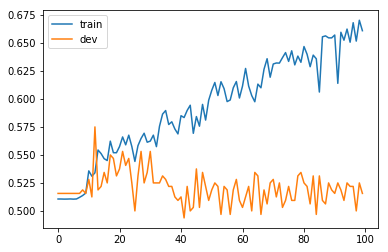

In [24]:
plt.plot(train_acc)
plt.plot(dev_acc)
plt.legend(('train','dev'))

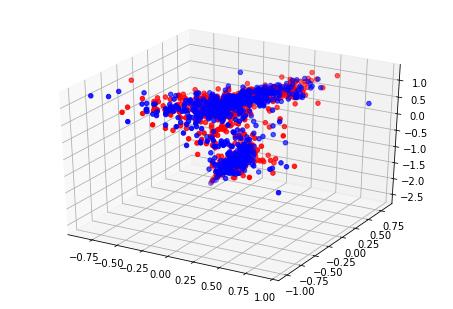

In [26]:
plot_3d_scatter(mean_data_set)

### 1.4 Experiment of Elmo encoded titles (mean with date)

In [52]:
reset_seed()

In [53]:
elmo_date_index=np.load('data/date_index_elmo.npy')
elmo_encoded_title=np.load('data/encoded_title_elmo.npy')

elmo_encoded_title=pd.DataFrame(elmo_encoded_title)

elmo_date_index=pd.DataFrame(elmo_date_index,columns=['date'])

elmo_encoded_title=elmo_date_index.join(elmo_encoded_title)

elmo_encoded_title.index=elmo_encoded_title.date

elmo_encoded_title.drop('date',axis=1,inplace=True)
mean_elmo_encoded_title=elmo_encoded_title.groupby('date').mean()
elmo_data_set=mean_title.join(labels).fillna(method='bfill').dropna()

In [54]:
# elmo_data_set.to_csv('data/elmo_embedding.csv')

# only use hidden states
x=np.array(elmo_data_set.iloc[:,:-1].values,dtype=np.float32)

y=np.array(elmo_data_set.iloc[:,-1].values,dtype=int)

In [55]:
model=DNNClassifier(input_size=x.shape[1],hidden_size=50,class_number=class_number)

In [56]:
train_loss,train_acc,dev_loss,dev_acc=test(model=model,x=x,y=y)

test loss 0.6930760145187378 test acc 0.515625 epoch: 0
test loss 0.6919849514961243 test acc 0.528125 epoch: 10
test loss 0.6907473802566528 test acc 0.5375 epoch: 20
test loss 0.6902903318405151 test acc 0.553125 epoch: 30
test loss 0.6924869418144226 test acc 0.5125 epoch: 40
test loss 0.6946593523025513 test acc 0.51875 epoch: 50
test loss 0.6984986066818237 test acc 0.503125 epoch: 60
test loss 0.7000682353973389 test acc 0.528125 epoch: 70
test loss 0.7035843133926392 test acc 0.525 epoch: 80
test loss 0.707969069480896 test acc 0.515625 epoch: 90


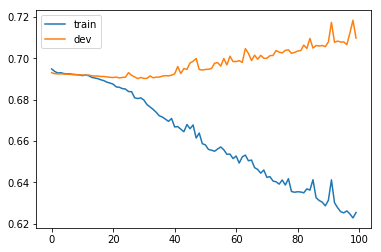

In [57]:
plt.plot(train_loss)
plt.plot(dev_loss)
plt.legend(('train','dev'))

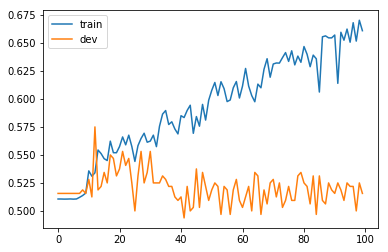

In [58]:
plt.plot(train_acc)
plt.plot(dev_acc)
plt.legend(('train','dev'))

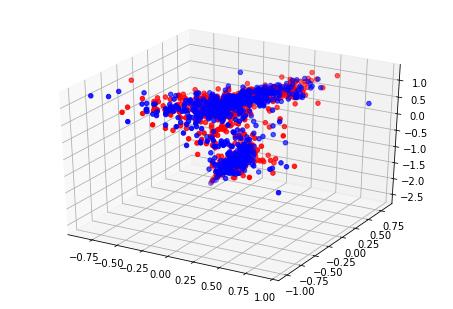

In [60]:
plot_3d_scatter(elmo_data_set)

## 2. RNN Experiments

### 2.1 Build RNN Classifier

In [68]:
# -*- coding:utf-8 -*-

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
import numpy as np
import os


class RNN(nn.Module):
    def __init__(self, input_shape, hidden_size, class_number):
        super(RNN, self).__init__()
        self.gru = nn.GRU(input_shape, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
#         self.fc2 = nn.Linear(hidden_size//2, hidden_size // 4)
        self.fc_out = nn.Linear(hidden_size // 2, class_number)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x, hidden):
        _, hidden = self.gru(x, hidden)
        output = self.relu(self.fc1(hidden))
#         output = self.relu(self.fc2(output))
        output = self.fc_out(output)
        output = self.softmax(output)
        return output


class RNNClassifier(object):
    def __init__(self, input_shape, hidden_size, class_number):
        super(RNNClassifier, self).__init__()
        self.rnn = RNN(input_shape, hidden_size, class_number=class_number)
        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.rnn.parameters(), lr=1e-3)
    
    def train(self, X, y):
        batch_x = torch.tensor(X)
        batch_y = torch.tensor(y)
        batch_x=(batch_x-batch_x.mean(dim=1,keepdim=True))/batch_x.std(dim=1,keepdim=True)
        instance_num = batch_y.shape[0]
        self.optimizer.zero_grad()
        y_hat = self.rnn(batch_x, hidden=None).squeeze(0)
        loss = self.loss_func(y_hat, batch_y)
#         print('train loss:', loss)
        loss.backward()
        clip_grad_norm_(self.rnn.parameters(), 1)
        self.optimizer.step()
        topv, topi = y_hat.topk(1)
        incorrect=float(torch.sign((topi.view(-1) - batch_y).abs()).sum().item())
        acc = (instance_num - incorrect) / instance_num
#         print('train acc', acc)
        return loss.item(),acc
    
    def test(self, X, y):
        batch_x = torch.tensor(X)
        batch_y = torch.tensor(y)
        batch_x=(batch_x-batch_x.mean(dim=1,keepdim=True))/batch_x.std(dim=1,keepdim=True)
        instance_num = batch_y.shape[0]
        y_hat = self.rnn(batch_x, hidden=None).squeeze(0).detach()
        
        loss = self.loss_func(y_hat, batch_y)
        
        topv, topi = y_hat.topk(1)
        incorrect=float(torch.sign((topi.view(-1) - batch_y).abs()).sum().item())
        acc = (instance_num - incorrect) / instance_num
        return loss.item(),acc

### 2.2 Experiment of RNN auto-encoder encoded title, (mean with date)

In [69]:
reset_seed()

In [70]:
ae_date_index=np.load('data/date_index_ae.npy')
ae_encoded_title=np.load('data/encoded_title_ae.npy')

In [71]:
ae_encoded_title=pd.DataFrame(ae_encoded_title)

ae_date_index=pd.DataFrame(ae_date_index,columns=['date'])

ae_encoded_title=ae_date_index.join(ae_encoded_title)

ae_encoded_title.index=ae_encoded_title.date
ae_encoded_title.drop('date',axis=1,inplace=True)

mean_ae_encoded_title=ae_encoded_title.groupby('date').mean()
ae_data_set=mean_ae_encoded_title.join(labels).fillna(method='bfill').dropna()

In [72]:
# ae_data_set.to_csv('data/ae_embedding.csv')

sequence_length=5

x=[]
y=[]
for i in range(sequence_length,ae_data_set.shape[0]):
    x.append(ae_data_set.iloc[i-sequence_length:i,:-1].values)
    y.append(ae_data_set.iloc[i-1,-1])
x=np.array(x,dtype=np.float32)
y=np.array(y,dtype=int)

In [73]:
model=RNNClassifier(input_shape=50,hidden_size=50,class_number=class_number)

In [74]:
train_loss,train_acc,dev_loss,dev_acc=test(model=model,x=x,y=y)

test loss 0.6932321190834045 test acc 0.47648902821316613 epoch: 0
test loss 0.6893766522407532 test acc 0.5579937304075235 epoch: 10
test loss 0.6876004338264465 test acc 0.5235109717868338 epoch: 20
test loss 0.6935558915138245 test acc 0.5454545454545454 epoch: 30
test loss 0.709561288356781 test acc 0.5611285266457681 epoch: 40
test loss 0.7117640972137451 test acc 0.5768025078369906 epoch: 50
test loss 0.7178784608840942 test acc 0.5736677115987461 epoch: 60
test loss 0.7230978012084961 test acc 0.5705329153605015 epoch: 70
test loss 0.7223184704780579 test acc 0.5705329153605015 epoch: 80
test loss 0.7212477922439575 test acc 0.5705329153605015 epoch: 90


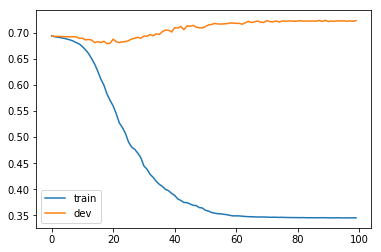

In [75]:
plt.plot(train_loss)
plt.plot(dev_loss)
plt.legend(('train','dev'))

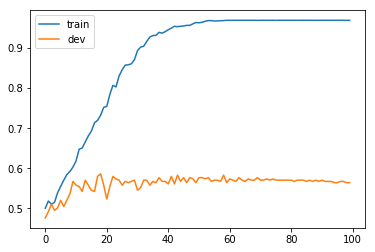

In [76]:
plt.plot(train_acc)
plt.plot(dev_acc)
plt.legend(('train','dev'))

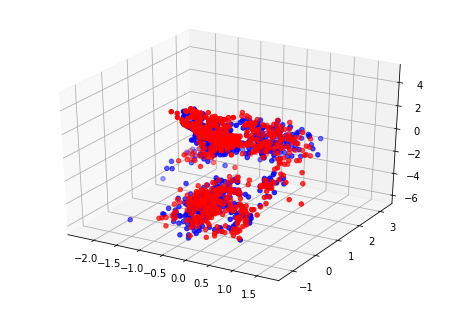

In [80]:
plot_3d_scatter(ae_data_set)

### 2.3 Experiment of pure Glove word embedding titles (mean with each title, mean with date)

In [88]:
reset_seed()

In [89]:
mean_title=pd.read_csv('data/mean_titles.csv')

mean_title.index=mean_title.date

mean_title.drop('date',axis=1,inplace=True)

mean_data_set=mean_title.join(labels).fillna(method='bfill').dropna()
# mean_data_set.to_csv('data/w2v_embedding.csv')

In [90]:
sequence_length=5

In [91]:
x=[]
y=[]
for i in range(sequence_length,mean_data_set.shape[0]):
    x.append(mean_data_set.iloc[i-sequence_length:i,:-1].values)
    y.append(mean_data_set.iloc[i-1,-1])

x=np.array(x,dtype=np.float32)

y=np.array(y,dtype=int)

In [92]:
model=RNNClassifier(input_shape=300,hidden_size=50,class_number=class_number)

In [93]:
train_loss,train_acc,dev_loss,dev_acc=test(model=model,x=x,y=y)

test loss 0.6923068761825562 test acc 0.5172413793103449 epoch: 0
test loss 0.6416625380516052 test acc 0.6300940438871473 epoch: 10
test loss 0.642153263092041 test acc 0.6426332288401254 epoch: 20
test loss 0.645646870136261 test acc 0.6551724137931034 epoch: 30
test loss 0.6457962393760681 test acc 0.6489028213166145 epoch: 40
test loss 0.6456108689308167 test acc 0.6489028213166145 epoch: 50
test loss 0.6454875469207764 test acc 0.6489028213166145 epoch: 60
test loss 0.6452722549438477 test acc 0.6489028213166145 epoch: 70
test loss 0.6449754238128662 test acc 0.6489028213166145 epoch: 80
test loss 0.6446714401245117 test acc 0.6520376175548589 epoch: 90


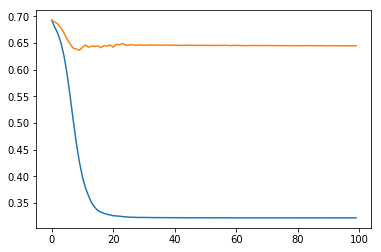

In [94]:
plt.plot(train_loss)
plt.plot(dev_loss)

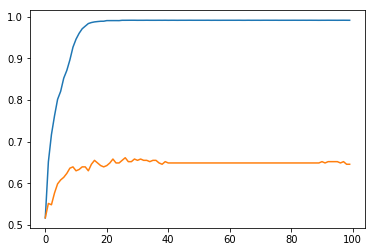

In [95]:
plt.plot(train_acc)
plt.plot(dev_acc)

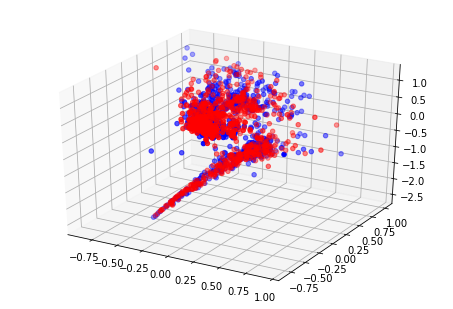

In [98]:
plot_3d_scatter(mean_data_set)

### 2.4 Experiment of Elmo encoded titles (mean with date)

In [125]:
reset_seed()

In [126]:
elmo_date_index=np.load('data/date_index_elmo.npy')
elmo_encoded_title=np.load('data/encoded_title_elmo.npy')
# elmo_encoded_title=(elmo_encoded_title-elmo_encoded_title.mean(axis=0))/elmo_encoded_title.std(axis=0)
elmo_encoded_title=pd.DataFrame(elmo_encoded_title)

elmo_date_index=pd.DataFrame(elmo_date_index,columns=['date'])

elmo_encoded_title=elmo_date_index.join(elmo_encoded_title)

elmo_encoded_title.index=elmo_encoded_title.date

elmo_encoded_title.drop('date',axis=1,inplace=True)

mean_elmo_encoded_title=elmo_encoded_title.groupby('date').mean()
elmo_data_set=mean_elmo_encoded_title.join(labels).fillna(method='bfill').dropna()
# elmo_data_set.to_csv('data/elmo_embedding.csv')

In [127]:
sequence_length=5

In [128]:
x=[]
y=[]
for i in range(sequence_length,elmo_data_set.shape[0]):
    x.append(elmo_data_set.iloc[i-sequence_length:i,:-1].values)
    y.append(elmo_data_set.iloc[i-1,-1])

x=np.array(x,dtype=np.float32)

y=np.array(y,dtype=int)

In [129]:
model=RNNClassifier(input_shape=x.shape[-1],hidden_size=64,class_number=class_number)

In [130]:
train_loss,train_acc,dev_loss,dev_acc=test(model=model,x=x,y=y)

test loss 0.6921884417533875 test acc 0.5047021943573667 epoch: 0
test loss 0.6545807123184204 test acc 0.6238244514106583 epoch: 10
test loss 0.6643730998039246 test acc 0.6269592476489029 epoch: 20
test loss 0.6703411936759949 test acc 0.6112852664576802 epoch: 30
test loss 0.6709946990013123 test acc 0.6112852664576802 epoch: 40
test loss 0.6738228797912598 test acc 0.6144200626959248 epoch: 50
test loss 0.6747424006462097 test acc 0.6206896551724138 epoch: 60
test loss 0.6820175647735596 test acc 0.6050156739811913 epoch: 70
test loss 0.6824496388435364 test acc 0.6050156739811913 epoch: 80
test loss 0.6832081079483032 test acc 0.6081504702194357 epoch: 90


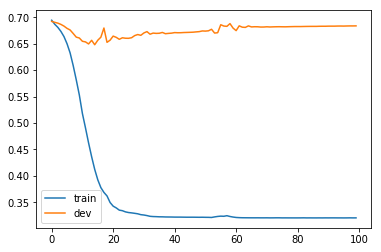

In [131]:
plt.plot(train_loss)
plt.plot(dev_loss)
plt.legend(('train','dev'))

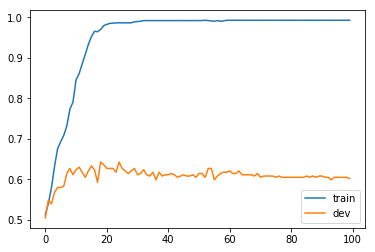

In [132]:
plt.plot(train_acc)
plt.plot(dev_acc)
plt.legend(('train','dev'))

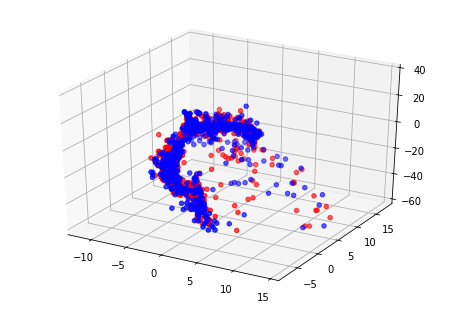

In [133]:
plot_3d_scatter(elmo_data_set)